In [243]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm, halfnorm, kstest, ks_2samp, wilcoxon, mannwhitneyu, probplot
from scipy.optimize import curve_fit
import pickle
from statsmodels.graphics.gofplots import qqplot_2samples
import operator

In [50]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [103]:
mars_unc = np.genfromtxt('harp_mars_unc.dat')
jupiter_unc = np.genfromtxt('harp_jupiter_unc.dat')
uranus_unc = np.genfromtxt('harp_uranus_unc.dat')
planets_unc = np.concatenate((mars_unc[:,9], jupiter_unc[:,8], uranus_unc[:,8]), axis=0)

In [109]:
yerr = np.mean(planets_unc[planets_unc!=0])
print(yerr)

0.102780674017


In [51]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]

In [52]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

In [203]:
def draw_samp(x, m, b, yerr_mu, yerr_sig, bias_mu, bias_sig, rel):
    result = []
    yerr = np.random.normal(yerr_mu, yerr_sig, size = len(x))
#     scatter = np.random.normal(scatter_mu, scatter_sig, size = len(x))
    bias = halfnorm.rvs(bias_mu, bias_sig, size = len(x))
#         print(yerr, scatter, bias)
    result = yerr - rel*bias + (m*x + b)
    return np.array(result)

In [390]:
sample = draw_samp(days, 0.0, .67, 0.0, .01, 0.0, .3, .7)

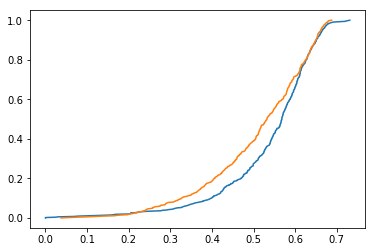

In [391]:
sort_y = np.sort(planets_etamb)
p = np.linspace(0, 1, len(planets_etamb))
data_CDF = lambda x: np.interp(x, sort_y, p)

#plotting CDF of data vs CDF of sample dataset
plt.figure(1)
plt.plot(sort_y, p)
plt.plot(np.sort(sample), p)
plt.show()

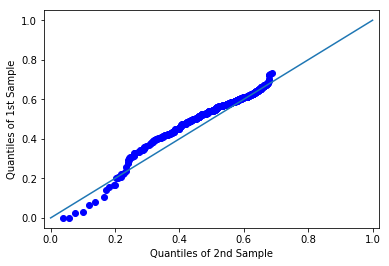

In [392]:
#qq plot for real data and "optimal param" data
plt.figure(1)
qqplot_2samples(planets_etamb, sample)
plt.plot(np.linspace(0.0,1.0),np.linspace(0.0,1.0))
plt.show()

In [286]:
def calc1000tests(m, b, yerr_mu, yerr_sig, bias_mu, bias_sig, rel):
    ks_stats = [] #each has 1000 test stats, corresponding to one set of params
    mwu_stats = []
    wilcoxon_stats = []
    ks_pv = [] #each has 1000 p-values, corresponding to one set of params
    mwu_pv = []
    wilcoxon_pv = []
    for i in range(1000):
        trial = draw_samp(days, m, b, yerr_mu, yerr_sig, bias_mu, bias_sig, rel)
        stat = ks_2samp(planets_etamb, trial)
        ks_stats.append(stat[0])
        ks_pv.append(stat[1])
        stat = mannwhitneyu(planets_etamb, trial, alternative = 'two-sided')
        mwu_stats.append(stat[0])
        mwu_pv.append(stat[1])
        stat = wilcoxon(planets_etamb, trial)
        wilcoxon_stats.append(stat[0])
        wilcoxon_pv.append(stat[1])
        
    return ks_stats, mwu_stats, wilcoxon_stats, ks_pv, mwu_pv, wilcoxon_pv

In [288]:
test_m = 0.0
test_b = .61
# test_yerr_mu = 0.0
# test_yerr_sig = .005
# test_bias_mu = 0.0
test_bias_sig = .08125
test_rel = 1.0
stats_ks, stats_mwu, stats_w, pvals_ks, pvals_mwu, pvals_w = calc1000tests(test_m, test_b, 0.0, 0.1, 0.0, test_bias_sig, test_rel)
print(stats_w)

[75613.0, 72949.0, 73288.0, 75190.0, 71910.0, 70945.0, 76022.0, 75503.0, 74280.0, 73375.0, 74321.0, 74377.0, 71826.0, 69530.0, 74553.0, 71813.0, 75490.0, 73572.0, 75619.0, 71233.0, 75401.0, 73407.0, 74883.0, 74723.0, 75455.0, 74408.0, 70112.0, 70677.0, 75533.0, 75963.0, 75739.0, 74367.0, 72904.0, 72357.0, 72770.0, 74792.0, 74443.0, 74680.0, 75702.0, 71138.0, 70411.0, 74295.0, 74223.0, 73281.0, 75998.0, 74683.0, 75032.0, 75503.0, 75781.0, 74723.0, 75513.0, 73534.0, 75957.0, 71921.0, 71653.0, 76004.0, 73649.0, 75940.0, 74087.0, 71381.0, 75121.0, 74951.0, 75341.0, 75816.0, 75980.0, 74399.0, 75611.0, 75699.0, 75736.0, 74553.0, 70239.0, 71100.0, 71064.0, 74699.0, 73162.0, 73090.0, 70246.0, 70182.0, 74653.0, 73093.0, 71946.0, 74558.0, 75476.0, 69363.0, 70978.0, 74438.0, 75909.0, 75397.0, 75205.0, 75777.0, 74130.0, 75488.0, 72779.0, 72095.0, 74091.0, 72315.0, 74216.0, 74720.0, 73791.0, 75486.0, 75938.0, 72600.0, 74900.0, 74749.0, 73100.0, 75027.0, 74635.0, 71877.0, 75340.0, 74431.0, 74617.0, 

In [168]:
# plt.figure(figsize=(12, 7))
# plt.plot(days, planets_etamb, 'bx')
# plt.plot(days, trial, 'rx')
# plt.xlabel('days')
# plt.ylabel('sampled values')
# plt.show()

In [266]:
#set range of params to test
num_trials = 5
m = np.linspace(-.001, .001, num=num_trials)
b = np.linspace(.5, .9, num=num_trials)
yerr_sig = np.linspace(0.01, .1, num=num_trials)
bias_sig = np.linspace(0.1, 1.0, num=num_trials)
rel = np.linspace(0.01, 2.0, num=num_trials)

In [289]:
#generate all test statistics, version without yerr and with rel
a, B, c, d = np.meshgrid(m, b, bias_sig, rel)
arr = np.stack((np.ravel(a), np.ravel(B), np.ravel(c), np.ravel(d)), axis=-1)

full_results = {}
for i in arr:
    print(i)
    stats_ks, stats_mwu, stats_w, pvals_ks, pvals_mwu, pvals_w = calc1000tests(i[0], i[1], 0.0, yerr, 0.0, i[2], i[3]) #each an array of 1000 pvals
    full_results[str(i)] = [[stats_ks, pvals_ks], [stats_mwu, pvals_mwu], [stats_w, pvals_w]]

[-0.001  0.5    0.1    0.01 ]
[-0.001   0.5     0.1     0.5075]
[ -1.00000000e-03   5.00000000e-01   1.00000000e-01   1.00500000e+00]
[ -1.00000000e-03   5.00000000e-01   1.00000000e-01   1.50250000e+00]
[ -1.00000000e-03   5.00000000e-01   1.00000000e-01   2.00000000e+00]
[-0.001  0.5    0.225  0.01 ]
[-0.001   0.5     0.225   0.5075]
[ -1.00000000e-03   5.00000000e-01   2.25000000e-01   1.00500000e+00]
[ -1.00000000e-03   5.00000000e-01   2.25000000e-01   1.50250000e+00]
[ -1.00000000e-03   5.00000000e-01   2.25000000e-01   2.00000000e+00]
[-0.001  0.5    0.35   0.01 ]
[-0.001   0.5     0.35    0.5075]
[ -1.00000000e-03   5.00000000e-01   3.50000000e-01   1.00500000e+00]
[ -1.00000000e-03   5.00000000e-01   3.50000000e-01   1.50250000e+00]
[ -1.00000000e-03   5.00000000e-01   3.50000000e-01   2.00000000e+00]
[-0.001  0.5    0.475  0.01 ]
[-0.001   0.5     0.475   0.5075]
[ -1.00000000e-03   5.00000000e-01   4.75000000e-01   1.00500000e+00]
[ -1.00000000e-03   5.00000000e-01   4.75000

[ -5.00000000e-04   6.00000000e-01   1.00000000e-01   1.00500000e+00]
[ -5.00000000e-04   6.00000000e-01   1.00000000e-01   1.50250000e+00]
[ -5.00000000e-04   6.00000000e-01   1.00000000e-01   2.00000000e+00]
[ -5.00000000e-04   6.00000000e-01   2.25000000e-01   1.00000000e-02]
[ -5.00000000e-04   6.00000000e-01   2.25000000e-01   5.07500000e-01]
[ -5.00000000e-04   6.00000000e-01   2.25000000e-01   1.00500000e+00]
[ -5.00000000e-04   6.00000000e-01   2.25000000e-01   1.50250000e+00]
[ -5.00000000e-04   6.00000000e-01   2.25000000e-01   2.00000000e+00]
[ -5.00000000e-04   6.00000000e-01   3.50000000e-01   1.00000000e-02]
[ -5.00000000e-04   6.00000000e-01   3.50000000e-01   5.07500000e-01]
[ -5.00000000e-04   6.00000000e-01   3.50000000e-01   1.00500000e+00]
[ -5.00000000e-04   6.00000000e-01   3.50000000e-01   1.50250000e+00]
[ -5.00000000e-04   6.00000000e-01   3.50000000e-01   2.00000000e+00]
[ -5.00000000e-04   6.00000000e-01   4.75000000e-01   1.00000000e-02]
[ -5.00000000e-04   

[ -5.00000000e-04   7.00000000e-01   6.00000000e-01   1.00000000e-02]
[ -5.00000000e-04   7.00000000e-01   6.00000000e-01   5.07500000e-01]
[ -5.00000000e-04   7.00000000e-01   6.00000000e-01   1.00500000e+00]
[ -5.00000000e-04   7.00000000e-01   6.00000000e-01   1.50250000e+00]
[ -5.00000000e-04   7.00000000e-01   6.00000000e-01   2.00000000e+00]
[ 0.    0.7   0.1   0.01]
[ 0.      0.7     0.1     0.5075]
[ 0.     0.7    0.1    1.005]
[ 0.      0.7     0.1     1.5025]
[ 0.   0.7  0.1  2. ]
[ 0.     0.7    0.225  0.01 ]
[ 0.      0.7     0.225   0.5075]
[ 0.     0.7    0.225  1.005]
[ 0.      0.7     0.225   1.5025]
[ 0.     0.7    0.225  2.   ]
[ 0.    0.7   0.35  0.01]
[ 0.      0.7     0.35    0.5075]
[ 0.     0.7    0.35   1.005]
[ 0.      0.7     0.35    1.5025]
[ 0.    0.7   0.35  2.  ]
[ 0.     0.7    0.475  0.01 ]
[ 0.      0.7     0.475   0.5075]
[ 0.     0.7    0.475  1.005]
[ 0.      0.7     0.475   1.5025]
[ 0.     0.7    0.475  2.   ]
[ 0.    0.7   0.6   0.01]
[ 0.      0.

[  5.00000000e-04   8.00000000e-01   1.00000000e-01   1.00500000e+00]
[  5.00000000e-04   8.00000000e-01   1.00000000e-01   1.50250000e+00]
[  5.00000000e-04   8.00000000e-01   1.00000000e-01   2.00000000e+00]
[  5.00000000e-04   8.00000000e-01   2.25000000e-01   1.00000000e-02]
[  5.00000000e-04   8.00000000e-01   2.25000000e-01   5.07500000e-01]
[  5.00000000e-04   8.00000000e-01   2.25000000e-01   1.00500000e+00]
[  5.00000000e-04   8.00000000e-01   2.25000000e-01   1.50250000e+00]
[  5.00000000e-04   8.00000000e-01   2.25000000e-01   2.00000000e+00]
[  5.00000000e-04   8.00000000e-01   3.50000000e-01   1.00000000e-02]
[  5.00000000e-04   8.00000000e-01   3.50000000e-01   5.07500000e-01]
[  5.00000000e-04   8.00000000e-01   3.50000000e-01   1.00500000e+00]
[  5.00000000e-04   8.00000000e-01   3.50000000e-01   1.50250000e+00]
[  5.00000000e-04   8.00000000e-01   3.50000000e-01   2.00000000e+00]
[  5.00000000e-04   8.00000000e-01   4.75000000e-01   1.00000000e-02]
[  5.00000000e-04   

[  5.00000000e-04   9.00000000e-01   6.00000000e-01   1.00000000e-02]
[  5.00000000e-04   9.00000000e-01   6.00000000e-01   5.07500000e-01]
[  5.00000000e-04   9.00000000e-01   6.00000000e-01   1.00500000e+00]
[  5.00000000e-04   9.00000000e-01   6.00000000e-01   1.50250000e+00]
[  5.00000000e-04   9.00000000e-01   6.00000000e-01   2.00000000e+00]
[ 0.001  0.9    0.1    0.01 ]
[ 0.001   0.9     0.1     0.5075]
[  1.00000000e-03   9.00000000e-01   1.00000000e-01   1.00500000e+00]
[  1.00000000e-03   9.00000000e-01   1.00000000e-01   1.50250000e+00]
[  1.00000000e-03   9.00000000e-01   1.00000000e-01   2.00000000e+00]
[ 0.001  0.9    0.225  0.01 ]
[ 0.001   0.9     0.225   0.5075]
[  1.00000000e-03   9.00000000e-01   2.25000000e-01   1.00500000e+00]
[  1.00000000e-03   9.00000000e-01   2.25000000e-01   1.50250000e+00]
[  1.00000000e-03   9.00000000e-01   2.25000000e-01   2.00000000e+00]
[ 0.001  0.9    0.35   0.01 ]
[ 0.001   0.9     0.35    0.5075]
[  1.00000000e-03   9.00000000e-01   3

In [210]:
#generate all test statistics, version with yerr
e, f, g, h = np.meshgrid(m, b, yerr_sig, bias_sig)
arr2 = np.stack((np.ravel(d), np.ravel(e), np.ravel(f), np.ravel(g)), axis=-1)

full_results_yerr = {}
for i in arr2:
    pvals_ks, pvals_mwu, pvals_w = calc1000tests(i[0], i[1], 0.0, i[2], 0.0, i[3]) #each an array of 1000 pvals
    full_results_yerr[str(i)] = [pvals_ks, pvals_mwu, pvals_w]

TypeError: calc1000tests() missing 1 required positional argument: 'rel'

In [268]:
#print all test p value means
for tests in full_results.values():
    print("ks mean: ", np.mean(tests[0][1]))
    print("mwu mean: ", np.mean(tests[1][1]))
    print("wilcoxon mean: ", np.mean(tests[2][1]))

ks mean:  3.46033922034e-181
mwu mean:  1.00152436556e-166
wilcoxon mean:  8.91624623638e-91
ks mean:  5.38321237789e-187
mwu mean:  9.03116355897e-171
wilcoxon mean:  3.8380414239e-91
ks mean:  6.83144698974e-191
mwu mean:  1.21894857555e-172
wilcoxon mean:  2.16661133277e-91
ks mean:  6.69787633006e-198
mwu mean:  1.12147434887e-174
wilcoxon mean:  1.48810255896e-91
ks mean:  8.99786569555e-203
mwu mean:  1.06407197713e-175
wilcoxon mean:  1.19080943155e-91
ks mean:  1.93330323779e-181
mwu mean:  3.18588059948e-167
wilcoxon mean:  8.93992161014e-91
ks mean:  2.74150718213e-195
mwu mean:  1.68358178618e-172
wilcoxon mean:  1.9100948223e-91
ks mean:  1.12171999963e-202
mwu mean:  2.19722790837e-176
wilcoxon mean:  1.06655613352e-91
ks mean:  3.11557248104e-208
mwu mean:  1.25735836833e-177
wilcoxon mean:  8.27638313848e-92
ks mean:  8.91487699812e-213
mwu mean:  2.11517192195e-178
wilcoxon mean:  7.41657856441e-92
ks mean:  8.76860130819e-181
mwu mean:  4.1528049092e-167
wilcoxon mean:

mwu mean:  1.02288252786e-105
wilcoxon mean:  5.90171329414e-83
ks mean:  5.28505256422e-134
mwu mean:  7.42749953743e-69
wilcoxon mean:  4.40819274601e-67
ks mean:  6.48224720547e-113
mwu mean:  1.07304076003e-43
wilcoxon mean:  1.93399985273e-47
ks mean:  2.59093237479e-91
mwu mean:  5.13266403829e-24
wilcoxon mean:  6.05464513589e-30
ks mean:  1.72630482425e-194
mwu mean:  1.51507613116e-152
wilcoxon mean:  3.58777726828e-91
ks mean:  5.91650378122e-152
mwu mean:  2.79711911511e-92
wilcoxon mean:  3.80540584303e-79
ks mean:  9.28751369881e-121
mwu mean:  4.56892281634e-54
wilcoxon mean:  7.21362305322e-57
ks mean:  2.8345114659e-94
mwu mean:  1.27468106965e-26
wilcoxon mean:  1.40608948964e-32
ks mean:  1.58493168194e-73
mwu mean:  4.66052510742e-12
wilcoxon mean:  2.8873937397e-15
ks mean:  1.09601580169e-162
mwu mean:  5.73949713696e-151
wilcoxon mean:  5.10742472152e-89
ks mean:  3.26446737406e-169
mwu mean:  2.58444706327e-158
wilcoxon mean:  7.80134088499e-90
ks mean:  1.145022

ks mean:  1.26000143913e-111
mwu mean:  6.8067054893e-102
wilcoxon mean:  1.58318116096e-78
ks mean:  1.96026548096e-119
mwu mean:  7.9231726376e-114
wilcoxon mean:  1.22336775547e-81
ks mean:  2.13610866829e-126
mwu mean:  4.7560159104e-123
wilcoxon mean:  5.73746951134e-84
ks mean:  2.37438135481e-137
mwu mean:  1.20342947099e-130
wilcoxon mean:  1.10151273845e-85
ks mean:  1.04921905833e-104
mwu mean:  1.598815999e-88
wilcoxon mean:  1.19723167829e-74
ks mean:  2.70564136734e-121
mwu mean:  3.93138234559e-117
wilcoxon mean:  2.61016830808e-82
ks mean:  1.85317951366e-140
mwu mean:  1.97302451717e-133
wilcoxon mean:  2.24427957717e-86
ks mean:  7.06384255882e-156
mwu mean:  8.98215383403e-145
wilcoxon mean:  1.58201145841e-88
ks mean:  1.1181047256e-164
mwu mean:  8.02813770426e-149
wilcoxon mean:  1.10664613616e-89
ks mean:  9.94965495859e-105
mwu mean:  1.59405363057e-87
wilcoxon mean:  2.07973949046e-74
ks mean:  4.91228108307e-133
mwu mean:  2.04978620566e-127
wilcoxon mean:  5.8

mwu mean:  2.20044979747e-139
wilcoxon mean:  2.71176469163e-89
ks mean:  6.23563166992e-134
mwu mean:  8.04222410154e-80
wilcoxon mean:  8.44684525724e-66
ks mean:  2.88847351566e-94
mwu mean:  2.60275668238e-35
wilcoxon mean:  7.6315398864e-35
ks mean:  2.27170607518e-69
mwu mean:  1.27050565969e-11
wilcoxon mean:  1.73854116105e-11
ks mean:  3.47539041119e-234
mwu mean:  1.98206120763e-180
wilcoxon mean:  5.97938839505e-92
ks mean:  3.26450122819e-170
mwu mean:  5.37686868061e-125
wilcoxon mean:  1.2446176166e-85
ks mean:  4.85516477476e-110
mwu mean:  8.00118399078e-54
wilcoxon mean:  2.06473471297e-48
ks mean:  1.1689589728e-71
mwu mean:  1.73429321741e-15
wilcoxon mean:  1.90132016965e-14
ks mean:  7.21071140118e-47
mwu mean:  0.00673109152076
wilcoxon mean:  0.0182531340521
ks mean:  3.06940162294e-239
mwu mean:  3.52159211058e-181
wilcoxon mean:  5.95993671323e-92
ks mean:  2.46289836672e-233
mwu mean:  3.33381323488e-180
wilcoxon mean:  5.96699977358e-92
ks mean:  8.0615923039

In [399]:
#find greatest count/peak of histogram for each test
lowest_ks = np.inf
lowest_mwu = np.inf
lowest_w = np.inf
stat_num = 0 #0-test stats 1-p-values
for params, arr in full_results.items():
    counts_ks, bins_ks= np.histogram(arr[0][stat_num], bins=100)
    mu_ks, std_ks = norm.fit(arr[0][stat_num])
    counts_mwu, bins_mwu = np.histogram(arr[1][stat_num], bins=100)
    mu_mwu, std_mwu = norm.fit(arr[1][stat_num])
    counts_w, bins_w = np.histogram(arr[2][stat_num], bins=100)
    mu_w, std_w = norm.fit(arr[2][stat_num])
    print(mu_w)
    if mu_ks > lowest_ks:
        lowest_ks = mu_ks
        lowest_params_ks = params
        p_vals_ks = arr[0][1]
        stats_ks = arr[0][0]
    if mu_mwu > lowest_mwu:
        lowest_mwu = mu_mwu
        lowest_params_mwu = params
        p_vals_mwu = arr[1][1]
        stats_mwu = arr[1][0]
    if mu_w > lowest_w:
        lowest_w = mu_w
        lowest_params_w = params
        p_vals_w = arr[2][1]
        stats_w = arr[2][0]
print(lowest_w, np.mean(p_vals_w), lowest_params_w)
#index_ks, value_ks = max(enumerate(counts_ks), key=operator.itemgetter(1))
#bins_ks[index_ks] + bins_ks[index_ks+1])/2.0

486.703
330.66
229.18
165.122
121.705
481.345
208.733
102.864
58.719
38.373
481.751
136.614
56.916
29.257
17.633
474.015
95.039
34.709
17.687
10.188
471.914
68.942
24.275
11.916
6.874
1335.834
893.964
619.908
435.705
318.981
1317.874
559.075
278.27
155.696
99.458
1304.468
366.759
147.464
73.72
44.859
1288.297
253.435
90.675
44.909
27.417
1275.991
182.273
59.567
29.209
16.937
50063.13
33692.095
22990.294
16154.88
11716.112
49695.359
20778.26
9977.553
5628.603
3491.794
49205.994
13475.847
5198.856
2669.86
1564.171
48688.301
9133.476
3143.198
1507.443
902.636
48276.99
6563.528
2055.391
965.42
563.186
1604.61
2833.839
4639.42
7056.615
9975.115
1630.481
5222.694
11757.146
20701.158
30860.549
1667.915
8581.476
21969.44
37984.835
54553.285
1677.174
12832.416
33366.62
55715.983
73864.436
1699.057
17900.945
45244.515
71868.64
59240.272
285.372
595.983
1118.094
1821.287
2746.671
293.418
1281.398
3249.103
5926.085
9242.198
296.919
2313.699
6272.373
11884.495
18899.354
300.975
3574.399
10162.124
1

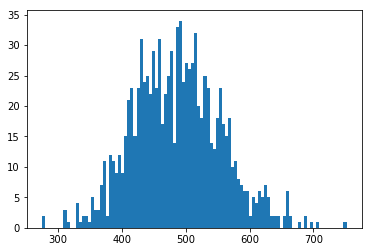

486.703


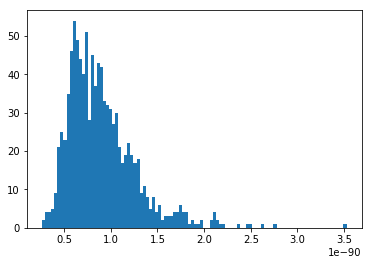

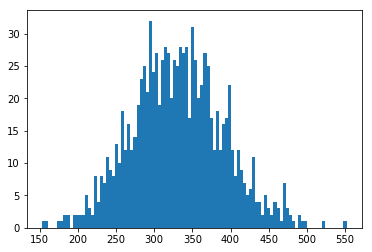

330.66


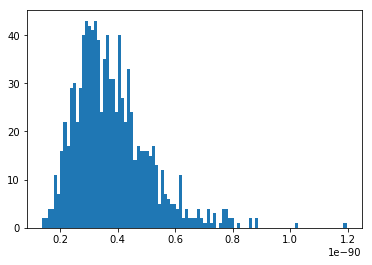

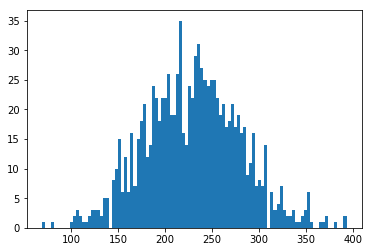

229.18


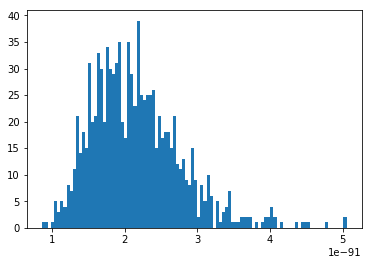

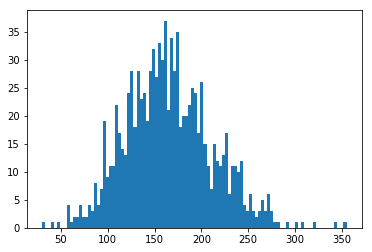

165.122


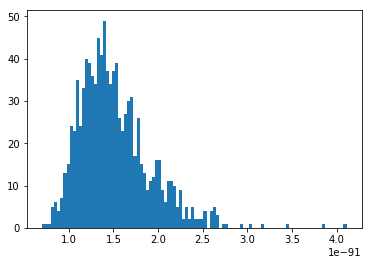

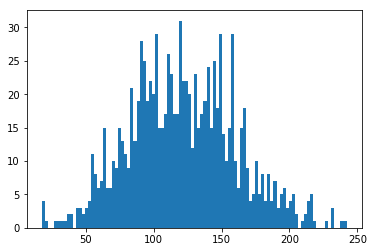

121.705


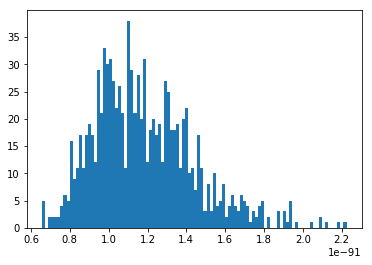

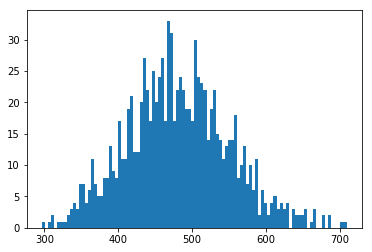

481.345


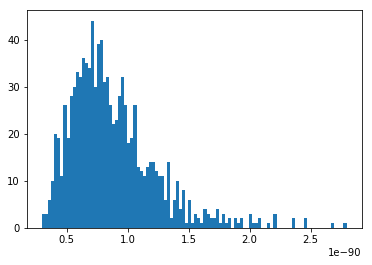

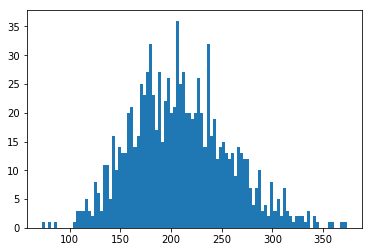

208.733


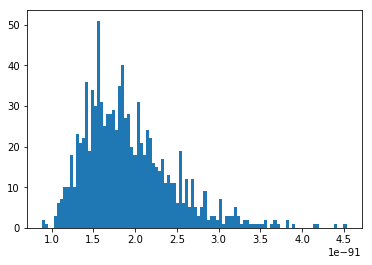

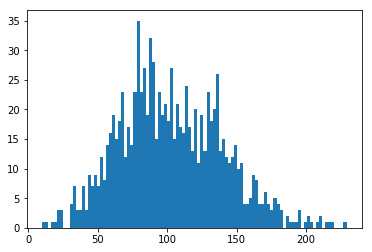

102.864


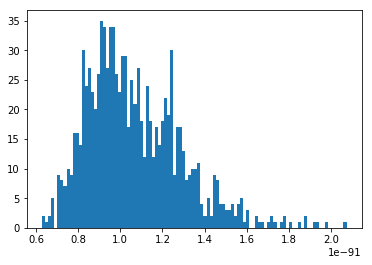

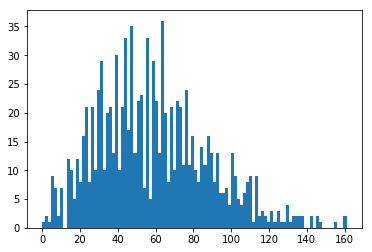

58.719


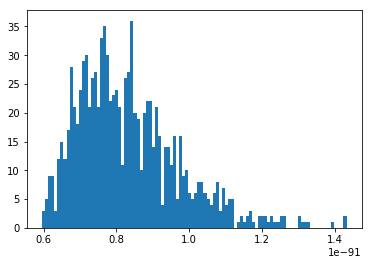

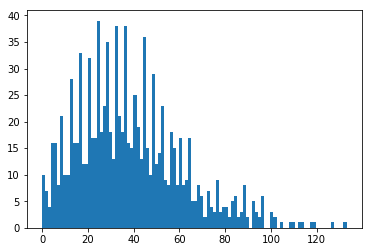

38.373


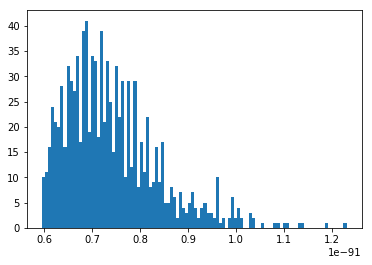

In [402]:
test_num = 2 # 0-ks 1-mwu 2-wilcoxon
stat_num = 0 #0-test stats 1-p-values
count = 0
for params, arr in full_results.items():
    mu, std = norm.fit(arr[test_num][stat_num])
    if count<10:
        plt.figure()
        counts, bins, patches = plt.hist(arr[test_num][stat_num], bins=100)
        plt.show()
        plt.figure()
        plt.hist(arr[test_num][1], bins=100)
#         index, value = max(enumerate(counts), key=operator.itemgetter(1))
#         print("max value: ", (bins[index] + bins[index+1])/2.0) 
#         print("mean value: ", np.mean(arr[test_num][stat_num]))
        print(mu)
        plt.show()
        count+=1

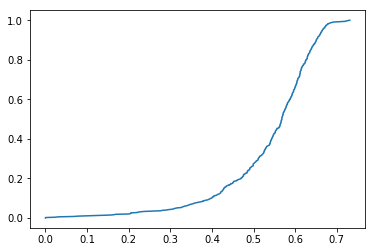

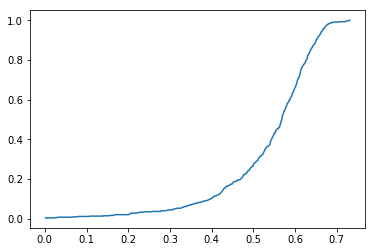

In [194]:
#two methods of plotting CDF (true dataset)
sort_y = np.sort(planets_etamb)
p = np.linspace(0, 1, len(planets_etamb))
data_CDF = lambda x: np.interp(x, sort_y, p)

plt.figure(1)
plt.plot(sort_y, p)
plt.show()

plt.figure(2)
num_bins = len(planets_etamb)
counts, bin_edges = np.histogram (planets_etamb, bins=num_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])
plt.show()

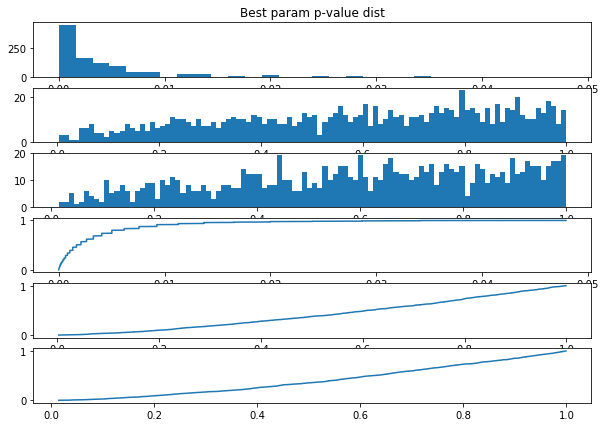

In [202]:
#plotting p value distribution and CDF of the p values
f, axarr = plt.subplots(6, figsize=(10, 7))
axarr[0].hist(p_vals_ks, bins=30)
axarr[0].set_title('Best param p-value dist')
axarr[1].hist(p_vals_mwu, bins=100)
axarr[2].hist(p_vals_w, bins=100)
ks = np.sort(p_vals_ks)
mwu = np.sort(p_vals_mwu)
w = np.sort(p_vals_w)
prob = np.linspace(0, 1, len(p_vals_w))
axarr[3].plot(ks, prob)
axarr[4].plot(mwu, prob)
axarr[5].plot(w, prob)
plt.show()

108135.422313 3.78393224488e-26
108135.422313 76035.0


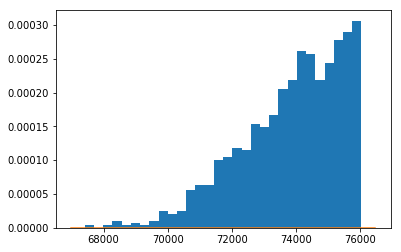

In [397]:
mu, std = halfnorm.fit(stats_w)
print(mu, std)
hist1, counts1, patches1 = plt.hist(stats_w, bins=30, normed=True)
index1, value1 = max(enumerate(counts1), key=operator.itemgetter(1))
print(mu, value1)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y)
plt.show()

In [396]:
print(np.sum(planets_etamb-sample))

16.0351198424


In [86]:
#to save results dictionary REMEMBER TO RENAME
pickle.dump(results, open(".p", "wb"))
#to read back in
#arr = pickle.load( open( "kstest_5param_5.p", "rb" ) )